In [1]:
# import the libraries
import simpy
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

### Set the starting or normal number of nodes.

In [2]:
number_of_nodes = 2

### Set up the simulation environment

In [3]:
# sim_env = simpy.Environment()
sim_env = simpy.rt.RealtimeEnvironment(factor=0.01, strict=False)

### Set up the variables to collect the statistics

In [4]:
# additional variables for statistics
nodes = []
probabilities = []
util = []
total_in_append = []
tasks_processing_append = []
still_processing_append = []
total_out_append = []
tasks_in_queue_append = []
simulation_time_append = []
time_spent = 0

## The simulation model

In [5]:
# the simpy-based simulation model

class TaskGenerator:
    """Generates the task"""

    def __init__(self, env, number_of_nodes):
        self.env = env
        self.number_of_nodes = number_of_nodes
        self.cpu_requested = 0
        self.task_id = 0
        self.process_time = 0
        self.initiate = env.process(self.generate_task())

    def generate_task(self):
#         for _ in range(self.number_of_nodes):
#                 node = simpy.Container(sim_env, init=1500, capacity=1500)
#                 nodes.append(node)

        while True:
            for _ in range(self.number_of_nodes):
                # create the node resources
                node = simpy.Container(sim_env, init=1500, capacity=1500)
                nodes.append(node)
                
                # variable to append cpu utilization
                i = []
                util.append(i)
                
            # inter_arrival time for tasks
            inter_arrival = np.random.uniform(2, 6)

            # append the task to the list
            total_in_append.append(1)

            # increment the task id
            self.task_id += 1

            # the cpu that is requested by the task
            self.cpu_requested = np.random.randint(100, 800)

            # the normal process time for the task
            self.process_time = np.random.randint(5, 20)

            # Servicing of task in the node
            self.env.process(ServiceTask(self.env,
                                         self.cpu_requested,
                                         self.process_time,
                                         self.number_of_nodes).service_task_in_node())

            # yield next task generation
            yield self.env.timeout(inter_arrival)

            # tasks in queue
            tasks_in_system = len(total_in_append) - len(total_out_append)
            tasks_in_process = len(tasks_processing_append) - len(total_out_append)
            if tasks_in_process > tasks_in_system:
                tasks_in_queue = 0
            else:
                tasks_in_queue = tasks_in_system - tasks_in_process
            
            # parameters to graph
            simulation_time_append.append(self.env.now)
            tasks_in_queue_append.append(tasks_in_queue)
            
            # auto scale the number of nodes
            # the node resources             
            if len(tasks_in_queue_append) > 25:
                self.number_of_nodes = 5
            else:
                self.number_of_nodes = number_of_nodes          
                              

In [6]:
class ServiceTask:
    """Services the task"""

    def __init__(self, env, cpu_requested, process_time, number_of_nodes):
        self.env = env
        self.cpu_requested = cpu_requested
        self.process_time = process_time
        self.number_of_nodes = number_of_nodes

    def service_task_in_node(self):
        global time_spent

        # Using the for loop in this method enables the scaling up or scaling down of nodes
        for i in range(self.number_of_nodes):
            # register the time that the task is received
            time_in = self.env.now

            # seize the requested cpu from the ith cpu_resource list
            yield nodes[i].get(self.cpu_requested)

            # seize the requested cpu for the specified process time
            yield self.env.timeout(self.process_time)

            # append the task to indicate the tasks in process
            tasks_processing_append.append(1)

            # return the cpu that was seized
            yield nodes[i].put(self.cpu_requested)

            # register the time that the task is completed
            time_out = self.env.now

            # compute the time the task spends in the system
            time_spent = round((time_out - time_in), 2)

            # append the task to the total out
            total_out_append.append(1)



Text(0, 0.5, 'Tasks in queue')

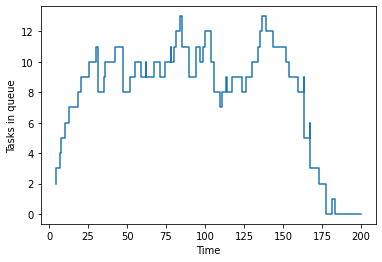

In [7]:
# activate the simulation environment
actuate = TaskGenerator(sim_env, number_of_nodes)
sim_env.process(actuate.generate_task())

# run the simulation  until 200 time units
sim_env.run(until=200)

# plot the tasks in queue
plt.figure()
plt.step(simulation_time_append, tasks_in_queue_append)
plt.xlabel("Time")
plt.ylabel("Tasks in queue")